Данные загружены с заголовками.
Размер датасета: (12000, 30)

Первые несколько строк датасета:


,id,num01,num02,num03,num04,num05,num06,num07,num08,num09,...,num20,num21,num22,num23,num24,cat_contract,cat_region,cat_payment,tenure_months,target
0,1,-0.946058,-0.070313,1.824445,-2.754422,0.808865,-0.111094,-0.268950,-3.078210,0.801275,...,-1.616515,-1.989464,1.407390,-0.218362,2.016052,0,2,3,33,0
1,2,-2.484027,0.739378,1.596908,-2.586479,-0.033225,-3.054412,-4.706908,-9.795169,0.145911,...,-1.727040,-0.583997,1.136761,0.285978,-0.310879,2,2,2,102,1
2,3,1.522629,7.159635,-0.564903,-4.493110,1.623610,5.450187,-0.974595,-5.189589,1.600591,...,0.524408,2.022430,1.278358,-0.850547,0.847457,1,0,2,3,0
3,4,0.463373,-1.073908,1.752813,0.362786,2.790872,4.082385,0.322283,3.390984,-0.033929,...,2.399834,-1.431576,-0.746987,0.049639,2.414689,1,0,1,50,0
4,5,3.188390,-4.701692,-0.689918,-0.448995,0.373821,-3.275363,-1.760931,0.923689,0.537345,...,-2.183407,-2.896590,2.440343,-1.097168,1.457323,1,2,3,81,0



Последний столбец: target

Уникальные значения в целевой переменной (target):
[0 1]
Количество уникальных классов: 2

Распределение целевой переменной:
target
0    67.658333
1    32.341667
Name: proportion, dtype: float64


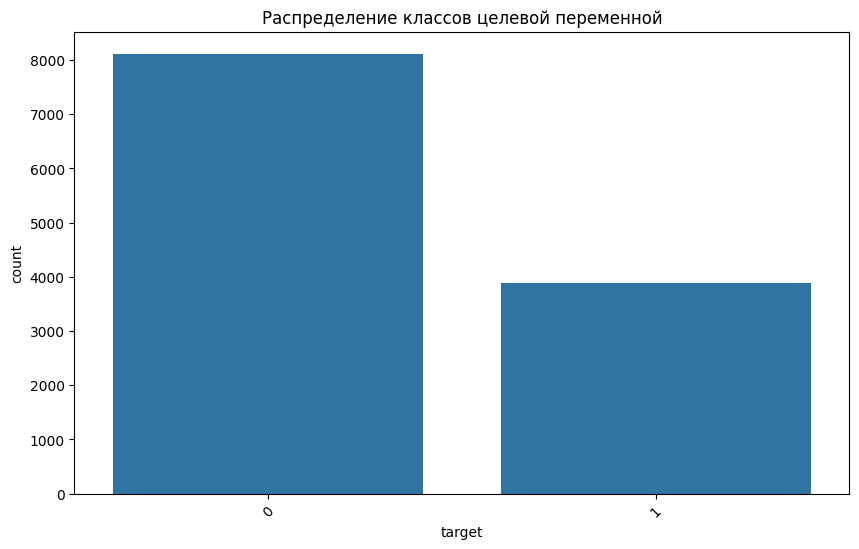


Тип задачи: бинарная
Количество классов: 2

Размер признаков: (12000, 29), Размер целевой переменной: (12000,)


In [44]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, label_binarize, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
import joblib
import json
import os
import warnings
warnings.filterwarnings('ignore')

# Фиксация случайного состояния для воспроизводимости
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Попытка загрузить данные с заголовками
try:
    df = pd.read_csv('S06-hw-dataset-01.csv')
    print("Данные загружены с заголовками.")
except Exception as e:
    print(f"Ошибка при загрузке с заголовками: {e}")
    # Если не удалось, загружаем без заголовков
    df = pd.read_csv('S06-hw-dataset-01.csv', header=None)
    print("Данные загружены без заголовков.")

# Анализ структуры данных
print("Размер датасета:", df.shape)

# Отображение первых нескольких строк для понимания структуры
print("\nПервые несколько строк датасета:")
display(df.head())

# Проверка, содержит ли первый столбец строковые значения (возможно, это 'id')
if df.iloc[:, 0].dtype == 'object':
    # Удаляем первый столбец, если он содержит строковые значения
    print("\nПервый столбец содержит строковые значения. Удаляем его.")
    df = df.drop(df.columns[0], axis=1)

# Проверка последнего столбца
last_col = df.columns[-1] if isinstance(df.columns[-1], str) else f'col_{df.shape[1]-1}'
print(f"\nПоследний столбец: {last_col}")

# Если последний столбец называется 'target', используем его
if 'target' in df.columns:
    target_col = 'target'
else:
    # Если нет столбца 'target', предполагаем, что последний столбец - целевая переменная
    target_col = df.columns[-1]
    # Переименовываем последний столбец в 'target'
    df = df.rename(columns={target_col: 'target'})
    target_col = 'target'

# Проверка и преобразование типов данных целевой переменной
if df[target_col].dtype == 'object':
    print(f"\nЦелевая переменная содержит нечисловые значения. Преобразуем в категории.")
    le = LabelEncoder()
    df[target_col] = le.fit_transform(df[target_col])
    print(f"Кодировка классов: {dict(zip(le.classes_, range(len(le.classes_))))}")

# Определение признаков (все столбцы кроме целевой переменной)
feature_cols = [col for col in df.columns if col != target_col]

# Анализ целевой переменной
print("\nУникальные значения в целевой переменной (target):")
unique_targets = df[target_col].unique()
print(unique_targets)
print(f"Количество уникальных классов: {len(unique_targets)}")

# Проверка распределения целевой переменной
print("\nРаспределение целевой переменной:")
target_counts = df[target_col].value_counts(normalize=True) * 100
print(target_counts)

# Построение графика распределения классов
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x=target_col, order=target_counts.index)
plt.title('Распределение классов целевой переменной')
plt.xticks(rotation=45)
os.makedirs('artifacts/figures', exist_ok=True)
plt.savefig('artifacts/figures/target_distribution.png')
plt.show()

# Определение типа задачи
n_classes = len(unique_targets)
is_multiclass = n_classes > 2
print(f"\nТип задачи: {'мультиклассовая' if is_multiclass else 'бинарная'}")
print(f"Количество классов: {n_classes}")

# Проверка и преобразование типов данных признаков
for col in feature_cols:
    if df[col].dtype == 'object':
        print(f"\nСтолбец {col} содержит нечисловые значения. Преобразуем в числовой формат.")
        try:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            df[col] = df[col].fillna(df[col].mean())
        except:
            print(f"Не удалось преобразовать столбец {col}. Используем LabelEncoder.")
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))

# Разделение на признаки и целевую переменную
X = df[feature_cols].copy()
y = df[target_col].copy()

# Преобразование y в целочисленный формат для гарантии корректной работы
y = y.astype(int)

print(f"\nРазмер признаков: {X.shape}, Размер целевой переменной: {y.shape}")

In [45]:
# Проверка, есть ли в признаках нечисловые значения
for col in X.columns:
    if X[col].dtype == 'object':
        print(f"\nСтолбец {col} содержит нечисловые значения. Преобразуем в числовой формат.")
        X[col] = pd.to_numeric(X[col], errors='coerce')
        X[col] = X[col].fillna(X[col].mean())

# Проверка минимального количества образцов в классах для стратификации
class_counts = y.value_counts()
min_class_count = class_counts.min()
print(f"Минимальное количество образцов в классе: {min_class_count}")

# Проверка, можно ли использовать стратификацию
if min_class_count < 5:
    print("Внимание: в некоторых классах недостаточно образцов для стратификации.")
    stratify_param = None
else:
    stratify_param = y

# Разделение данных на train и test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE, 
    stratify=stratify_param
)

print(f"Обучающая выборка: {X_train.shape[0]} образцов")
print(f"Тестовая выборка: {X_test.shape[0]} образцов")

# Проверка распределения классов в обучающей и тестовой выборках
print("\nРаспределение классов в обучающей выборке:")
print(y_train.value_counts(normalize=True) * 100)
print("\nРаспределение классов в тестовой выборке:")
print(y_test.value_counts(normalize=True) * 100)

# Краткое пояснение
"""
Использование фиксированного random_state (42) гарантирует воспроизводимость результатов между запусками.
Стратификация применяется для сохранения распределения классов в обучающей и тестовой выборках, как в исходных данных, если в каждом классе достаточно образцов.
Это особенно важно для задач классификации, особенно при дисбалансе классов.
"""

Минимальное количество образцов в классе: 3881
Обучающая выборка: 9600 образцов
Тестовая выборка: 2400 образцов

Распределение классов в обучающей выборке:
target
0    67.65625
1    32.34375
Name: proportion, dtype: float64

Распределение классов в тестовой выборке:
target
0    67.666667
1    32.333333
Name: proportion, dtype: float64


'\nИспользование фиксированного random_state (42) гарантирует воспроизводимость результатов между запусками.\nСтратификация применяется для сохранения распределения классов в обучающей и тестовой выборках, как в исходных данных, если в каждом классе достаточно образцов.\nЭто особенно важно для задач классификации, особенно при дисбалансе классов.\n'

In [46]:
# Инициализация хранилища метрик
metrics_results = {}
best_params = {}

# Определение стратегии усреднения для мультиклассовой задачи
average_strategy = 'macro' if is_multiclass else 'binary'

# 1. DummyClassifier как baseline
dummy_clf = DummyClassifier(strategy='stratified', random_state=RANDOM_STATE)
dummy_clf.fit(X_train, y_train)
y_pred_dummy = dummy_clf.predict(X_test)

# Расчет метрик
dummy_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_dummy),
    'f1': f1_score(y_test, y_pred_dummy, average=average_strategy)
}

# ROC-AUC для мультикласса
if is_multiclass:
    train_classes = np.unique(y_train)
    y_test_bin = label_binarize(y_test, classes=train_classes)
    
    if hasattr(dummy_clf, "predict_proba"):
        y_prob_dummy = dummy_clf.predict_proba(X_test)
        roc_auc_scores = []
        for i in range(min(y_test_bin.shape[1], y_prob_dummy.shape[1])):
            if len(np.unique(y_test_bin[:, i])) > 1:  # Проверка, есть ли оба класса
                try:
                    roc_auc_scores.append(roc_auc_score(y_test_bin[:, i], y_prob_dummy[:, i]))
                except ValueError:
                    continue
        dummy_metrics['roc_auc'] = np.mean(roc_auc_scores) if roc_auc_scores else None
    else:
        dummy_metrics['roc_auc'] = None
else:
    if hasattr(dummy_clf, "predict_proba"):
        y_prob_dummy = dummy_clf.predict_proba(X_test)[:, 1]
        try:
            dummy_metrics['roc_auc'] = roc_auc_score(y_test, y_prob_dummy)
        except ValueError:
            dummy_metrics['roc_auc'] = None
    else:
        dummy_metrics['roc_auc'] = None

metrics_results['DummyClassifier'] = dummy_metrics

print("Метрики DummyClassifier (стратегия 'stratified'):")
for metric, value in dummy_metrics.items():
    print(f"{metric}: {value:.4f}" if value is not None else f"{metric}: не рассчитан")

# 2. LogisticRegression как baseline
log_reg_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, solver='lbfgs'))
])

log_reg_pipe.fit(X_train, y_train)
y_pred_logreg = log_reg_pipe.predict(X_test)

# Расчет метрик
logreg_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_logreg),
    'f1': f1_score(y_test, y_pred_logreg, average=average_strategy)
}

# ROC-AUC для мультикласса
if is_multiclass:
    train_classes = np.unique(y_train)
    y_test_bin = label_binarize(y_test, classes=train_classes)
    
    if hasattr(log_reg_pipe, "predict_proba"):
        y_prob_logreg = log_reg_pipe.predict_proba(X_test)
        roc_auc_scores = []
        for i in range(min(y_test_bin.shape[1], y_prob_logreg.shape[1])):
            if len(np.unique(y_test_bin[:, i])) > 1:
                try:
                    roc_auc_scores.append(roc_auc_score(y_test_bin[:, i], y_prob_logreg[:, i]))
                except ValueError:
                    continue
        logreg_metrics['roc_auc'] = np.mean(roc_auc_scores) if roc_auc_scores else None
    else:
        logreg_metrics['roc_auc'] = None
else:
    if hasattr(log_reg_pipe, "predict_proba"):
        y_prob_logreg = log_reg_pipe.predict_proba(X_test)[:, 1]
        try:
            logreg_metrics['roc_auc'] = roc_auc_score(y_test, y_prob_logreg)
        except ValueError:
            logreg_metrics['roc_auc'] = None
    else:
        logreg_metrics['roc_auc'] = None

metrics_results['LogisticRegression'] = logreg_metrics

print("\nМетрики LogisticRegression:")
for metric, value in logreg_metrics.items():
    print(f"{metric}: {value:.4f}" if value is not None else f"{metric}: не рассчитан")

Метрики DummyClassifier (стратегия 'stratified'):
accuracy: 0.5754
f1: 0.3405
roc_auc: 0.5137

Метрики LogisticRegression:
accuracy: 0.8279
f1: 0.7081
roc_auc: 0.8749


In [47]:
# 1. DecisionTreeClassifier с контролем сложности
dt_params = {
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [1, 2, 5]
}

dt_clf = DecisionTreeClassifier(random_state=RANDOM_STATE)
dt_grid = GridSearchCV(dt_clf, dt_params, cv=3, scoring='f1_macro' if is_multiclass else 'roc_auc', n_jobs=-1)
dt_grid.fit(X_train, y_train)

# Сохранение лучших параметров
best_params['DecisionTree'] = {
    'params': dt_grid.best_params_,
    'cv_score': dt_grid.best_score_
}

# Оценка на тестовой выборке
dt_best = dt_grid.best_estimator_
y_pred_dt = dt_best.predict(X_test)

# Расчет метрик
dt_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_dt),
    'f1': f1_score(y_test, y_pred_dt, average=average_strategy)
}

# ROC-AUC для мультикласса
if is_multiclass:
    train_classes = np.unique(y_train)
    y_test_bin = label_binarize(y_test, classes=train_classes)
    
    if hasattr(dt_best, "predict_proba"):
        y_prob_dt = dt_best.predict_proba(X_test)
        roc_auc_scores = []
        for i in range(min(y_test_bin.shape[1], y_prob_dt.shape[1])):
            if len(np.unique(y_test_bin[:, i])) > 1:
                try:
                    roc_auc_scores.append(roc_auc_score(y_test_bin[:, i], y_prob_dt[:, i]))
                except ValueError:
                    continue
        dt_metrics['roc_auc'] = np.mean(roc_auc_scores) if roc_auc_scores else None
    else:
        dt_metrics['roc_auc'] = None
else:
    if hasattr(dt_best, "predict_proba"):
        y_prob_dt = dt_best.predict_proba(X_test)[:, 1]
        try:
            dt_metrics['roc_auc'] = roc_auc_score(y_test, y_prob_dt)
        except ValueError:
            dt_metrics['roc_auc'] = None
    else:
        dt_metrics['roc_auc'] = None

metrics_results['DecisionTree'] = dt_metrics

print("\nDecisionTreeClassifier - Лучшие параметры:", dt_grid.best_params_)
print("Метрики DecisionTreeClassifier:")
for metric, value in dt_metrics.items():
    print(f"{metric}: {value:.4f}" if value is not None else f"{metric}: не рассчитан")

# 2. RandomForestClassifier
rf_params = {
    'n_estimators': [50],
    'max_depth': [5, 10],
    'min_samples_leaf': [1, 2]
}

rf_clf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
rf_grid = GridSearchCV(rf_clf, rf_params, cv=3, scoring='f1_macro' if is_multiclass else 'roc_auc', n_jobs=-1)
rf_grid.fit(X_train, y_train)

# Сохранение лучших параметров
best_params['RandomForest'] = {
    'params': rf_grid.best_params_,
    'cv_score': rf_grid.best_score_
}

# Оценка на тестовой выборке
rf_best = rf_grid.best_estimator_
y_pred_rf = rf_best.predict(X_test)

# Расчет метрик
rf_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_rf),
    'f1': f1_score(y_test, y_pred_rf, average=average_strategy)
}

# ROC-AUC для мультикласса
if is_multiclass:
    train_classes = np.unique(y_train)
    y_test_bin = label_binarize(y_test, classes=train_classes)
    
    if hasattr(rf_best, "predict_proba"):
        y_prob_rf = rf_best.predict_proba(X_test)
        roc_auc_scores = []
        for i in range(min(y_test_bin.shape[1], y_prob_rf.shape[1])):
            if len(np.unique(y_test_bin[:, i])) > 1:
                try:
                    roc_auc_scores.append(roc_auc_score(y_test_bin[:, i], y_prob_rf[:, i]))
                except ValueError:
                    continue
        rf_metrics['roc_auc'] = np.mean(roc_auc_scores) if roc_auc_scores else None
    else:
        rf_metrics['roc_auc'] = None
else:
    if hasattr(rf_best, "predict_proba"):
        y_prob_rf = rf_best.predict_proba(X_test)[:, 1]
        try:
            rf_metrics['roc_auc'] = roc_auc_score(y_test, y_prob_rf)
        except ValueError:
            rf_metrics['roc_auc'] = None
    else:
        rf_metrics['roc_auc'] = None

metrics_results['RandomForest'] = rf_metrics

print("\nRandomForestClassifier - Лучшие параметры:", rf_grid.best_params_)
print("Метрики RandomForestClassifier:")
for metric, value in rf_metrics.items():
    print(f"{metric}: {value:.4f}" if value is not None else f"{metric}: не рассчитан")

# 3. GradientBoostingClassifier
if is_multiclass:
    from sklearn.ensemble import HistGradientBoostingClassifier
    
    gb_clf = HistGradientBoostingClassifier(random_state=RANDOM_STATE)
    gb_params = {
        'max_depth': [3, 5],
        'learning_rate': [0.1],
        'max_iter': [50]
    }
    scoring_metric = 'f1_macro'
else:
    gb_clf = GradientBoostingClassifier(random_state=RANDOM_STATE)
    gb_params = {
        'n_estimators': [50],
        'learning_rate': [0.1],
        'max_depth': [3, 5]
    }
    scoring_metric = 'roc_auc'

gb_grid = GridSearchCV(gb_clf, gb_params, cv=3, scoring=scoring_metric, n_jobs=-1)
gb_grid.fit(X_train, y_train)

# Сохранение лучших параметров
best_params['GradientBoosting'] = {
    'params': gb_grid.best_params_,
    'cv_score': gb_grid.best_score_
}

# Оценка на тестовой выборке
gb_best = gb_grid.best_estimator_
y_pred_gb = gb_best.predict(X_test)

# Расчет метрик
gb_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_gb),
    'f1': f1_score(y_test, y_pred_gb, average=average_strategy)
}

# ROC-AUC для мультикласса
if is_multiclass:
    train_classes = np.unique(y_train)
    y_test_bin = label_binarize(y_test, classes=train_classes)
    
    if hasattr(gb_best, "predict_proba"):
        y_prob_gb = gb_best.predict_proba(X_test)
        roc_auc_scores = []
        for i in range(min(y_test_bin.shape[1], y_prob_gb.shape[1])):
            if len(np.unique(y_test_bin[:, i])) > 1:
                try:
                    roc_auc_scores.append(roc_auc_score(y_test_bin[:, i], y_prob_gb[:, i]))
                except ValueError:
                    continue
        gb_metrics['roc_auc'] = np.mean(roc_auc_scores) if roc_auc_scores else None
    else:
        gb_metrics['roc_auc'] = None
else:
    if hasattr(gb_best, "predict_proba"):
        y_prob_gb = gb_best.predict_proba(X_test)[:, 1]
        try:
            gb_metrics['roc_auc'] = roc_auc_score(y_test, y_prob_gb)
        except ValueError:
            gb_metrics['roc_auc'] = None
    else:
        gb_metrics['roc_auc'] = None

metrics_results['GradientBoosting'] = gb_metrics

print("\nGradientBoostingClassifier - Лучшие параметры:", gb_grid.best_params_)
print("Метрики GradientBoostingClassifier:")
for metric, value in gb_metrics.items():
    print(f"{metric}: {value:.4f}" if value is not None else f"{metric}: не рассчитан")


DecisionTreeClassifier - Лучшие параметры: {'max_depth': 7, 'min_samples_leaf': 5}
Метрики DecisionTreeClassifier:
accuracy: 0.8567
f1: 0.7581
roc_auc: 0.8890

RandomForestClassifier - Лучшие параметры: {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 50}
Метрики RandomForestClassifier:
accuracy: 0.9104
f1: 0.8498
roc_auc: 0.9580

GradientBoostingClassifier - Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
Метрики GradientBoostingClassifier:
accuracy: 0.9108
f1: 0.8530
roc_auc: 0.9600



Лучшая модель: GradientBoosting
Метрики: {'accuracy': 0.9108333333333334, 'f1': 0.853021978021978, 'roc_auc': 0.9599650538316996}


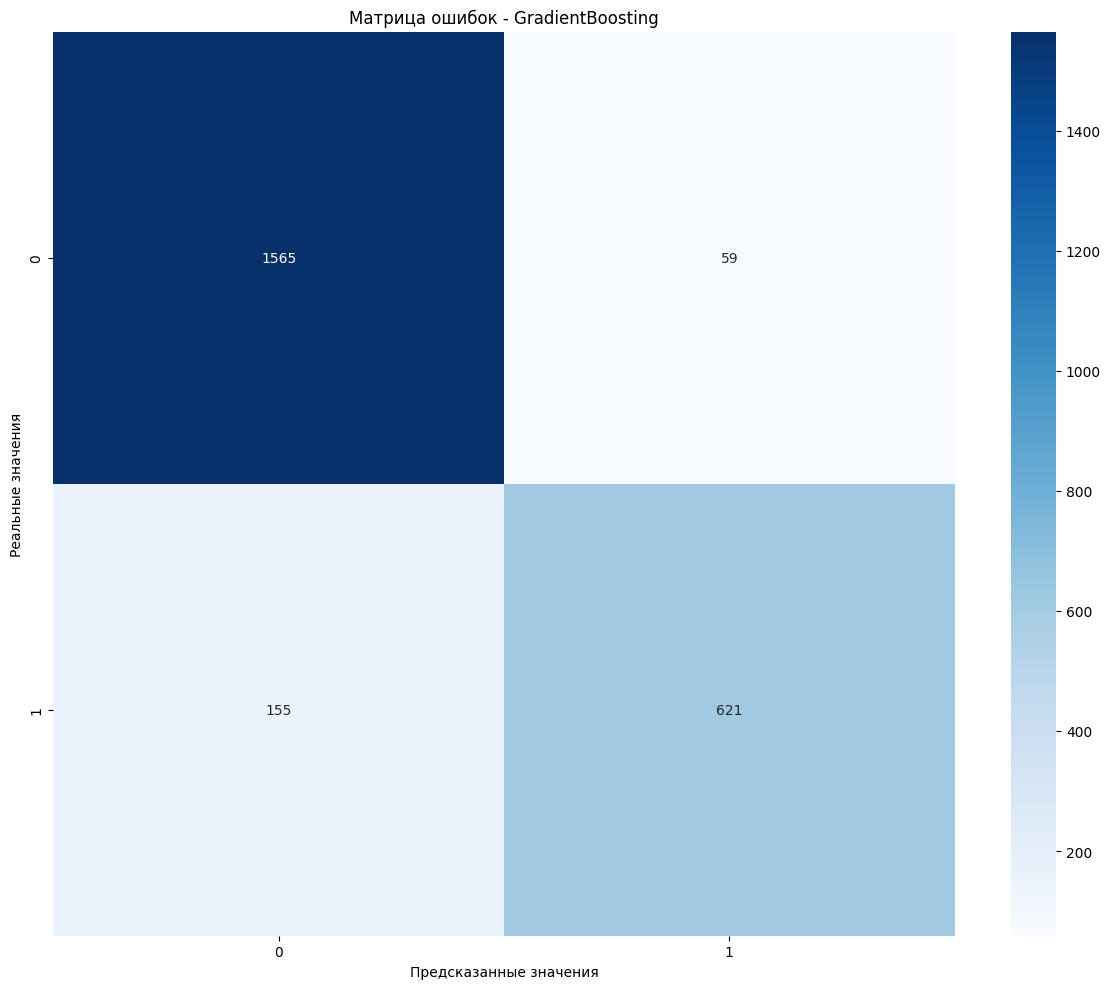

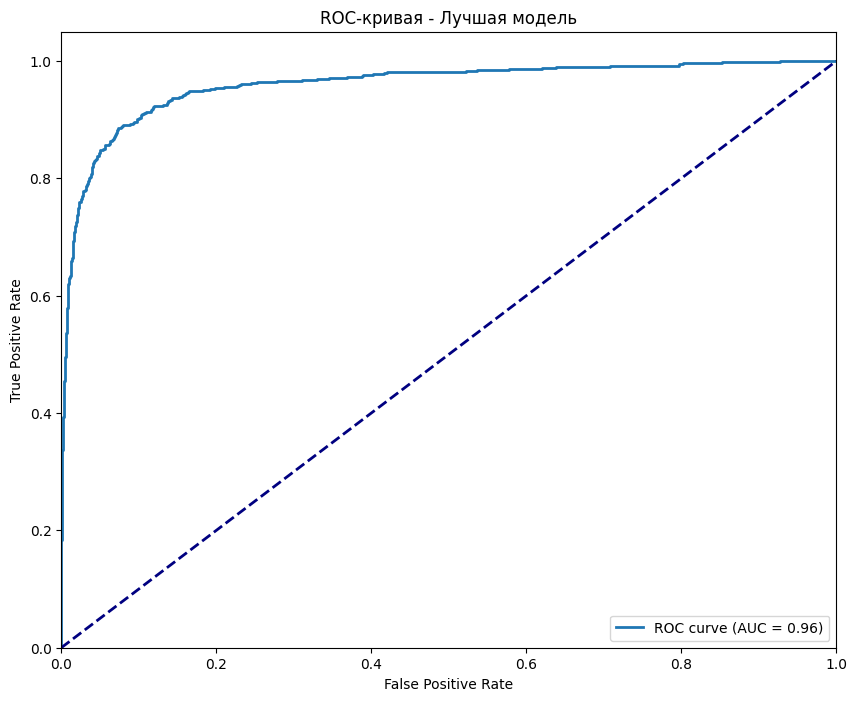

In [48]:
# Определение лучшей модели
if is_multiclass:
    best_model_name = max(metrics_results, key=lambda k: metrics_results[k]['f1'])
else:
    models_with_roc_auc = {k: v for k, v in metrics_results.items() if v['roc_auc'] is not None}
    if models_with_roc_auc:
        best_model_name = max(models_with_roc_auc, key=lambda k: models_with_roc_auc[k]['roc_auc'])
    else:
        best_model_name = max(metrics_results, key=lambda k: metrics_results[k]['f1'])

best_model_metrics = metrics_results[best_model_name]

print(f"\nЛучшая модель: {best_model_name}")
print(f"Метрики: {best_model_metrics}")

# Получение экземпляра лучшей модели
if best_model_name == 'DummyClassifier':
    best_model = dummy_clf
elif best_model_name == 'LogisticRegression':
    best_model = log_reg_pipe
elif best_model_name == 'DecisionTree':
    best_model = dt_best
elif best_model_name == 'RandomForest':
    best_model = rf_best
elif best_model_name == 'GradientBoosting':
    best_model = gb_best

# Построение матрицы ошибок для лучшей модели
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, best_model.predict(X_test))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title(f'Матрица ошибок - {best_model_name}')
plt.xlabel('Предсказанные значения')
plt.ylabel('Реальные значения')
plt.tight_layout()
plt.savefig('artifacts/figures/confusion_matrix.png')
plt.show()

# ROC-кривая
if hasattr(best_model, "predict_proba"):
    plt.figure(figsize=(10, 8))
    
    if is_multiclass:
        train_classes = np.unique(y_train)
        y_test_bin = label_binarize(y_test, classes=train_classes)
        y_prob = best_model.predict_proba(X_test)
        
        min_classes = min(y_test_bin.shape[1], y_prob.shape[1])
        y_test_bin = y_test_bin[:, :min_classes]
        y_prob = y_prob[:, :min_classes]
        
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        for i in range(min_classes):
            if len(np.unique(y_test_bin[:, i])) > 1:
                fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
                roc_auc[i] = auc(fpr[i], tpr[i])
        
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_prob.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        
        plt.plot(fpr["micro"], tpr["micro"], 
                 label=f'micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})',
                 color='deeppink', linestyle=':', linewidth=4)
        
        colors = plt.cm.tab10(np.linspace(0, 1, min_classes))
        for i, color in zip(range(min_classes), colors):
            if i in fpr:
                plt.plot(fpr[i], tpr[i], color=color, lw=2,
                         label=f'ROC curve of class {train_classes[i]} (AUC = {roc_auc[i]:.2f})')
        
        plt.title('Мультиклассовая ROC-кривая (One-vs-Rest)')
    else:
        y_prob = best_model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc_val = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc_val:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.title('ROC-кривая - Лучшая модель')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.savefig('artifacts/figures/roc_curve.png')
    plt.show()
else:
    print(f"Модель {best_model_name} не поддерживает predict_proba, ROC-кривая не построена")

Расчет permutation importance...


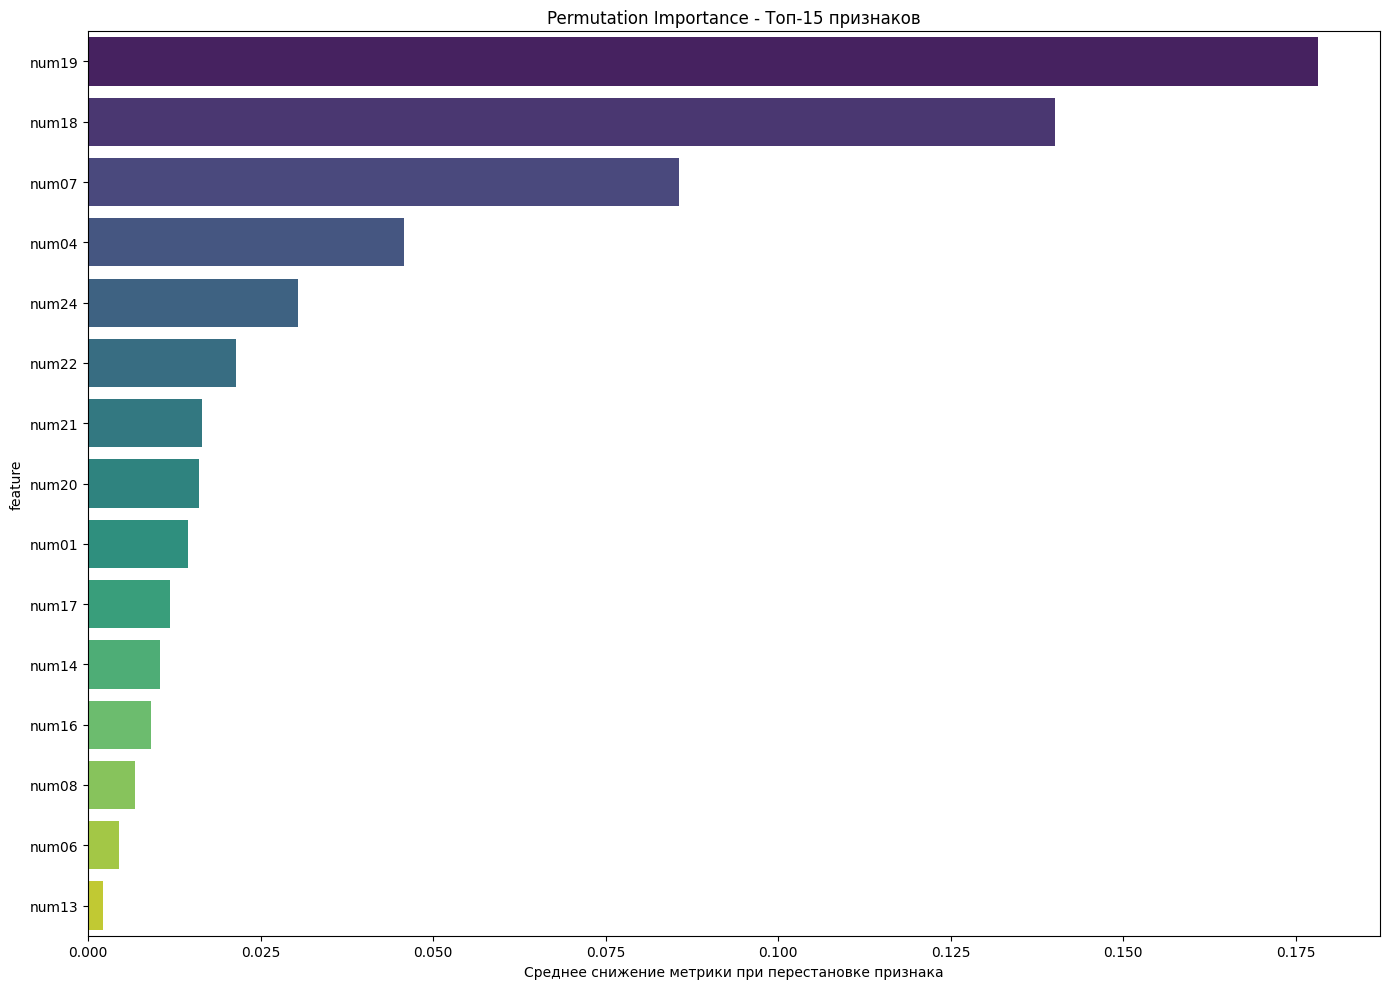


Топ-15 важных признаков:


,feature,importance,std
19,num19,0.178312,0.006700
18,num18,0.140131,0.009370
7,num07,0.085651,0.007414
4,num04,0.045749,0.006434
24,num24,0.030360,0.002645
22,num22,0.021393,0.001491
21,num21,0.016469,0.003294
20,num20,0.016087,0.005366
1,num01,0.014508,0.003864
17,num17,0.011812,0.006884



Интерпретация важности признаков:
Самый важный признак: num19 со значением важности 0.1783.
Это говорит о том, что данный признак оказывает наибольшее влияние на предсказания модели.
Важные признаки могут быть связаны с ключевыми характеристиками в предметной области задачи.


In [49]:
# Расчет permutation importance для лучшей модели
try:
    # Обработка pipeline при необходимости
    model_to_use = best_model
    if hasattr(best_model, 'named_steps') and 'logreg' in best_model.named_steps:
        model_to_use = best_model.named_steps['logreg']
    
    # Расчет важности признаков
    print("Расчет permutation importance...")
    perm_importance = permutation_importance(
        model_to_use, X_test, y_test, 
        n_repeats=5, random_state=RANDOM_STATE, n_jobs=-1,
        scoring='f1_macro' if is_multiclass else 'f1'
    )
    
    # Подготовка данных для отображения
    importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': perm_importance.importances_mean,
        'std': perm_importance.importances_std
    })
    
    # Сортировка по важности
    importance_df = importance_df.sort_values('importance', ascending=False)
    
    # Построение графика для топ-15 признаков
    plt.figure(figsize=(14, 10))
    sns.barplot(
        data=importance_df.head(15), 
        x='importance', 
        y='feature',
        orient='h',
        palette='viridis'
    )
    plt.title('Permutation Importance - Топ-15 признаков')
    plt.xlabel('Среднее снижение метрики при перестановке признака')
    plt.tight_layout()
    plt.savefig('artifacts/figures/permutation_importance.png')
    plt.show()
    
    # Вывод топ-15 важных признаков
    print("\nТоп-15 важных признаков:")
    display(importance_df.head(15))
    
    # Краткая интерпретация
    print("\nИнтерпретация важности признаков:")
    top_feature = importance_df.iloc[0]['feature']
    top_importance = importance_df.iloc[0]['importance']
    print(f"Самый важный признак: {top_feature} со значением важности {top_importance:.4f}.")
    print("Это говорит о том, что данный признак оказывает наибольшее влияние на предсказания модели.")
    print("Важные признаки могут быть связаны с ключевыми характеристиками в предметной области задачи.")
except Exception as e:
    print(f"Ошибка при расчете permutation importance: {e}")

In [50]:
# Создание директории artifacts, если она не существует
os.makedirs('artifacts/figures', exist_ok=True)

# 1. Сохранение метрик в JSON
serializable_metrics = {}
for model, metrics in metrics_results.items():
    serializable_metrics[model] = {}
    for k, v in metrics.items():
        if isinstance(v, (np.floating, np.float32, np.float64)):
            serializable_metrics[model][k] = float(v)
        elif isinstance(v, (np.integer, np.int32, np.int64)):
            serializable_metrics[model][k] = int(v)
        elif v is None:
            serializable_metrics[model][k] = "not available"
        else:
            serializable_metrics[model][k] = v

with open('artifacts/metrics_test.json', 'w') as f:
    json.dump(serializable_metrics, f, indent=4, ensure_ascii=False)

# 2. Сохранение результатов подбора гиперпараметров
serializable_params = {}
for model, params in best_params.items():
    serializable_params[model] = {}
    for k, v in params.items():
        if isinstance(v, dict):
            serializable_params[model][k] = {}
            for kk, vv in v.items():
                if isinstance(vv, (np.floating, np.float32, np.float64)):
                    serializable_params[model][k][kk] = float(vv)
                elif isinstance(vv, (np.integer, np.int32, np.int64)):
                    serializable_params[model][k][kk] = int(vv)
                else:
                    serializable_params[model][k][kk] = vv
        elif isinstance(v, (np.floating, np.float32, np.float64)):
            serializable_params[model][k] = float(v)
        elif isinstance(v, (np.integer, np.int32, np.int64)):
            serializable_params[model][k] = int(v)
        else:
            serializable_params[model][k] = v

with open('artifacts/search_summaries.json', 'w') as f:
    json.dump(serializable_params, f, indent=4, ensure_ascii=False)

# 3. Сохранение лучшей модели
joblib.dump(best_model, 'artifacts/best_model.joblib')

# 4. Сохранение метаданных модели
best_model_meta = {
    'best_model_name': best_model_name,
    'best_params': best_params.get(best_model_name.split()[0], {}).get('params', {}),
    'metrics': {k: (float(v) if isinstance(v, (np.floating, float)) else v) for k, v in best_model_metrics.items()},
    'is_multiclass': is_multiclass,
    'n_classes': n_classes
}

with open('artifacts/best_model_meta.json', 'w') as f:
    json.dump(best_model_meta, f, indent=4, ensure_ascii=False)

print("\nВсе артефакты успешно сохранены.")


Все артефакты успешно сохранены.
